# Combining Raw Data
Chapter 4 of the book: "Build Your Own AI Investor"

In [1]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [2]:
from platform import python_version
print(python_version())

3.7.7


In [5]:
#https://simfin.com/
def getXDataMerged():
    a=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/us-income-annual/us-income-annual.csv', delimiter=';')
    b=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/us-balance-annual/us-balance-annual.csv', delimiter=';')
    c=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/us-cashflow-annual/us-cashflow-annual.csv', delimiter=';')
    print('Income Statement CSV is: ', a.shape)
    print('Balance Sheet CSV is: ', b.shape)
    print('Cash Flow CSV is: ' ,c.shape)
    result = pd.merge(a, b, on=['Ticker','SimFinId','Currency','Fiscal Year','Report Date','Publish Date'])
    result = pd.merge(result, c, on=['Ticker','SimFinId','Currency','Fiscal Year','Report Date','Publish Date'])
    result["Report Date"] = pd.to_datetime(result["Report Date"])
    result["Publish Date"] = pd.to_datetime(result["Publish Date"])
    print('merged X data matrix shape is:', result.shape)
    return result

In [6]:
def getYRawData():
    d=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/us-shareprices-daily/us-shareprices-daily.csv', delimiter=';')
    d["Date"]=pd.to_datetime(d["Date"])
    print('Stock Price data matrix is: ',d.shape)
    return d

In [7]:
# return just the y price and volume near date (as have imperfect data).
# Want the volume data returned to remove stocks with near 0 volume later.
# d is just the raw Y data
# modifier just modifies the date to look between. Can be done differently.
def getYPriceDataNearDate(ticker, date, modifier, d):
    windowDays=5
    rows = \
    d[(d["Date"].between(pd.to_datetime(date) + pd.Timedelta(days=modifier),\
       pd.to_datetime(date) + pd.Timedelta(days=windowDays+modifier))) \
      & (d["Ticker"]==ticker)]
    if rows.empty:
        return [ticker, np.float("NaN"),\
                np.datetime64('NaT'),\
                np.float("NaN")]
    else:
        return [ticker, rows.iloc[0]["Open"],\
                rows.iloc[0]["Date"],\
                rows.iloc[0]["Volume"]*rows.iloc[0]["Open"]]
        #take the first item of the list of days that fall in the window of accepted days.

In [8]:
d=getYRawData()

Stock Price data matrix is:  (5289952, 10)


In [9]:
getYPriceDataNearDate('AAPL', '2012-05-12', 0, d)

['AAPL', 80.3671, Timestamp('2012-05-14 00:00:00'), 1012127183.9799999]

In [10]:
getYPriceDataNearDate('AAPL', '2012-05-12', 30, d)

['AAPL', 83.96, Timestamp('2012-06-11 00:00:00'), 1772949735.9999998]

In [11]:
# modifier is effectively the hold period for a stock.
# x is the vector of company data
# d is the Y raw data (stock price and date for all days)
def getYPricesReportDateAndTargetDate(x, d, modifier=365):
    i=0
    
    # Preallocation list of list of 2 \
    # [(price at date) (price at date + modifier)]
    y = [[None]*8 for i in range(len(x))] 
    
    whichDateCol='Publish Date'# or 'Report Date', \
    # is the performance date from->to. Want this to be publish date.
    
    # Because of time lag between report date\
    # (which can't be actioned on) and publish date\
    # (data we can trade with)
    for index in range(len(x)):
        y[i]=(getYPriceDataNearDate(\
            x['Ticker'].iloc[index], x[whichDateCol].iloc[index], 0, d) + \
              getYPriceDataNearDate(\
            x['Ticker'].iloc[index], x[whichDateCol].iloc[index], modifier, d))
        i=i+1
    return y

In [9]:
x = getXDataMerged()
x.to_csv("Annual_Stock_Price_Fundamentals.csv")

Income Statement CSV is:  (15479, 28)
Balance Sheet CSV is:  (15479, 30)
Cash Flow CSV is:  (15479, 28)
merged X data matrix shape is: (15479, 74)


In [10]:
x.keys()

Index(['Ticker', 'SimFinId', 'Currency', 'Fiscal Year', 'Fiscal Period_x',
       'Report Date', 'Publish Date', 'Restated Date_x', 'Shares (Basic)_x',
       'Shares (Diluted)_x', 'Revenue', 'Cost of Revenue', 'Gross Profit',
       'Operating Expenses', 'Selling, General & Administrative',
       'Research & Development', 'Depreciation & Amortization_x',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_y', 'Restated Date_y', 'Shares (Basic)_y',
       'Shares (Diluted)_y', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Ter

In [11]:
d = getYRawData()
d[d['Ticker']=='GOOG']

Stock Price data matrix is:  (5289952, 10)


,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume
0,GOOG,18,2014-03-27,568.000,552.92,568.00,558.46,558.46,NaN,13100
1,GOOG,18,2014-03-28,561.200,558.67,566.43,559.99,559.99,NaN,41100
2,GOOG,18,2014-03-31,566.890,556.93,567.00,556.97,556.97,NaN,10800
3,GOOG,18,2014-04-01,558.710,558.71,568.45,567.16,567.16,NaN,7900
4,GOOG,18,2014-04-02,565.106,562.19,604.83,567.00,567.00,NaN,146700
...,...,...,...,...,...,...,...,...,...,...
1319,GOOG,18,2019-06-24,1119.610,1111.01,1122.00,1115.52,1115.52,NaN,1395696
1320,GOOG,18,2019-06-25,1112.660,1083.80,1114.35,1086.35,1086.35,NaN,1546913
1321,GOOG,18,2019-06-26,1086.500,1072.24,1092.97,1079.80,1079.80,NaN,1810869
1322,GOOG,18,2019-06-27,1084.000,1075.29,1087.10,1076.01,1076.01,NaN,1004477


In [11]:
# We want to know the performance for each stock, each year, between 10-K report dates.
# takes VERY long time, several hours.
y = getYPricesReportDateAndTargetDate(x, d, 365) # because of lookups in this function.

Stock Price data matrix is:  (5289952, 10)


In [12]:
y= pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume', 'Ticker2', 'Open Price2', 'Date2', 'Volume2'])
y.to_csv("Annual_Stock_Price_Performance.csv")

NameError: name 'y' is not defined

In [ ]:
y

In [6]:
x=pd.read_csv("Annual_Stock_Price_Fundamentals.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance.csv", index_col=0)

In [7]:
# Find out things about data visually.
#x[x["Ticker"]=="GOOG"]['Income (Loss) from Continuing Operations'].hist()#bins=50, figsize=(20,15))
#x.keys()

#x.describe()
#x.hist(bins=50, figsize=(20,15))

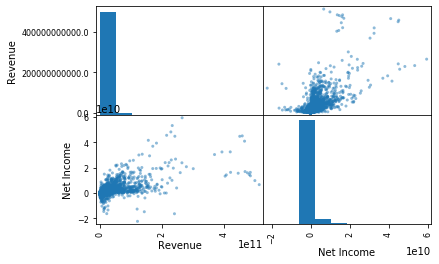

In [8]:
from pandas.plotting import scatter_matrix
attributes=["Revenue","Net Income"]
scatter_matrix(x[attributes]);

In [9]:
# Find out things about Y data
print("Y Shape:", y.shape)
print("X Shape:", x.shape)

Y Shape: (15479, 8)
X Shape: (15479, 74)


In [10]:
y[(y['Volume']<1e4) | (y['Volume2']<1e4)]

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
32,AAN,15.6667,2010-02-03,0.0000,AAN,19.500,2011-02-03,7121400.000
128,ABCD,1.1965,2013-03-08,4277.4875,ABCD,2.100,2014-03-10,150225.600
153,ABMC,0.1200,2011-02-14,240.0000,ABMC,0.160,2012-02-14,496.000
154,ABMC,0.1600,2012-02-14,496.0000,ABMC,0.220,2013-02-13,220.000
155,ABMC,0.1990,2013-03-28,348.2500,ABMC,0.115,2014-03-28,714.725
...,...,...,...,...,...,...,...,...
15461,ZYXI,0.5600,2013-03-28,30968.0000,ZYXI,0.430,2014-03-28,43.000
15462,ZYXI,0.4300,2014-03-28,43.0000,ZYXI,0.140,2015-03-30,518.000
15463,ZYXI,0.1400,2015-03-31,182.0000,ZYXI,0.340,2016-03-30,0.000
15464,ZYXI,0.3400,2016-03-31,34.0000,ZYXI,0.310,2017-03-31,217.000


In [11]:
# Now need to filter out rows because not all of the rows have stock performance.

In [12]:
## PROBLEMS
# no accounting for mergers or bankrupcies (use adjusted share closing price)

In [13]:
# Issue where no share price
bool_list = ~y["Open Price"].isnull()
y=y[bool_list]
x=x[bool_list]

# Issues where no listed number of shares
bool_list = ~x["Shares (Diluted)_x"].isnull()
y=y[bool_list]
x=x[bool_list]

# Issue where there is low/no volume
bool_list =   ~((y['Volume']<1e4) | (y['Volume2']<1e4))
y=y[bool_list]
x=x[bool_list]

# Issue where dates missing (Removes latest data too, which we can't use)
bool_list = ~y["Date2"].isnull()
y=y[bool_list]
x=x[bool_list]
               
y=y.reset_index(drop=True)
x=x.reset_index(drop=True)

In [14]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,66.33,2018-12-20,2.353265e+08,A,NaN,NaN,NaN
1,AA,30.70,2019-02-26,1.143155e+08,AA,NaN,NaN,NaN
2,AAL,35.75,2019-02-25,3.898869e+08,AAL,NaN,NaN,NaN
3,AAMC,39.32,2019-02-27,2.843622e+05,AAMC,NaN,NaN,NaN
4,AAN,48.38,2019-02-14,7.371186e+07,AAN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1752,ZUMZ,24.11,2019-03-18,1.883844e+07,ZUMZ,NaN,NaN,NaN
1753,ZVO,6.60,2019-03-12,3.432370e+06,ZVO,NaN,NaN,NaN
1754,ZYNE,4.80,2019-03-11,2.979552e+06,ZYNE,NaN,NaN,NaN
1755,ZYXI,5.60,2019-02-26,2.684080e+05,ZYXI,NaN,NaN,NaN


In [30]:
x["Market Cap"] = y["Open Price"]*x["Shares (Diluted)_x"]

In [31]:
x.shape

(12088, 75)

In [32]:
y.shape

(12088, 8)

In [33]:
x.to_csv("Annual_Stock_Price_Fundamentals_Filtered.csv")
y.to_csv("Annual_Stock_Price_Performance_Filtered.csv")

In [34]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.12,2009-01-05,8.269076e+07,A,31.21,2010-01-05,9.345210e+07
1,A,29.60,2009-12-21,9.319856e+07,A,40.65,2010-12-21,1.469619e+08
2,A,37.59,2010-12-08,1.262986e+08,A,36.23,2011-12-08,1.566078e+08
3,A,33.73,2011-12-16,1.053320e+08,A,39.98,2012-12-17,1.381149e+08
4,A,40.58,2012-12-20,1.545570e+08,A,57.47,2013-12-20,1.697664e+08
...,...,...,...,...,...,...,...,...
12083,low,49.11,2014-03-31,3.287473e+08,low,74.51,2015-03-31,3.366399e+08
12084,low,74.51,2015-03-31,3.366399e+08,low,75.89,2016-03-30,2.405867e+08
12085,low,75.04,2016-03-29,3.317825e+08,low,82.26,2017-03-29,3.264436e+08
12086,low,81.91,2017-04-04,4.091163e+08,low,84.32,2018-04-04,6.628260e+08


In [35]:
x[80:90]

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Market Cap
80,AAXN,493957,USD,2015,FY,2015-12-31,2016-03-07,2017-03-06,5.354800e+07,5.463800e+07,...,-6464000.0,-1.835900e+07,-11186000.0,-3.600900e+07,NaN,-8.000000e+04,-4883000.0,6.030000e+05,11159000,1.059977e+09
81,AAXN,493957,USD,2016,FY,2016-12-31,2017-03-06,2017-03-06,5.266700e+07,5.353600e+07,...,-8410000.0,8.865000e+06,-3500000.0,-3.045000e+06,NaN,-1.070000e+05,-33268000.0,-3.466100e+07,-18875000,1.220621e+09
82,AAXN,493957,USD,2017,FY,2017-12-31,2018-03-01,2018-03-01,5.272600e+07,5.389800e+07,...,-11419000.0,4.113000e+07,-10629000.0,1.908200e+07,NaN,-3.400000e+04,1383000.0,-3.854000e+06,34454000,1.881040e+09
83,ABAX,36105,USD,2011,FY,2012-03-31,2012-05-10,2013-06-14,2.236500e+07,2.285800e+07,...,-6926000.0,5.918000e+06,-2800000.0,-3.808000e+06,0.0,NaN,1684000.0,2.784000e+06,15614000,7.954584e+08
84,ABAX,36105,USD,2012,FY,2013-03-31,2014-05-30,2014-05-30,2.208400e+07,2.246200e+07,...,-7663000.0,1.614200e+07,NaN,8.479000e+06,0.0,NaN,-26713000.0,-2.791500e+07,2372000,9.434040e+08
85,ABAX,36105,USD,2013,FY,2014-03-31,2015-06-01,2015-06-01,2.194600e+07,2.238100e+07,...,-5636000.0,3.979000e+06,0.0,-1.657000e+06,-22023000.0,NaN,2800000.0,-1.816500e+07,9067000,1.186193e+09
86,ABAX,36105,USD,2014,FY,2015-03-31,2016-05-31,2016-05-31,2.227000e+07,2.257500e+07,...,-5510000.0,-7.848000e+06,0.0,-1.335800e+07,0.0,NaN,-1526000.0,-4.045000e+06,18679000,1.036192e+09
87,ABAX,36105,USD,2015,FY,2016-03-31,2016-05-31,2016-05-31,2.249700e+07,2.278700e+07,...,-6052000.0,-3.337000e+06,-618000.0,1.009300e+07,-9006000.0,NaN,31000.0,-1.096200e+07,33426000,1.045923e+09
88,ABAX,36105,USD,2016,FY,2017-03-31,2017-03-31,2017-03-31,2.266100e+07,2.288300e+07,...,-5185000.0,-1.482100e+07,-1131000.0,-2.023700e+07,-9970000.0,NaN,-13040000.0,-2.662700e+07,-18692000,1.104105e+09
89,ABBV,61199,USD,2012,FY,2012-12-31,2013-02-07,2015-02-20,1.577000e+09,1.577000e+09,...,-333000000.0,-1.397000e+09,-688000000.0,-2.418000e+09,NaN,1.558600e+10,NaN,1.931000e+09,5874000000,5.924789e+10


# X Data for Final Stock Selection 2020
Requires SimFin+ Bulk Download

## Get the Latest Share Prices (To make Market Cap. Column Soon)

In [12]:
def getYRawData2020():
    d=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/2020/us-shareprices-daily.csv', delimiter=';')
    d["Date"]=pd.to_datetime(d["Date"])
    print('Stock Price data matrix is: ',d.shape)
    return d

In [13]:
d=getYRawData2020()

Stock Price data matrix is:  (5779923, 11)


In [14]:
getYPriceDataNearDate('AAPL', '2020-02-21', 0, d)

['AAPL', 318.62, Timestamp('2020-02-21 00:00:00'), 10331704347.3]

## Functions to Extract Price at Time We Need and Combine X Data

In [15]:
# Get the stock prices for our X matrix to create Market Cap. column later.
def getYPricesReportDate(x, d, modifier=365):
    i=0
    y = [[None]*8 for i in range(len(x))] # Preallocation list of list of 2 [(price at date) (price at date + modifier)]
    whichDateCol='Publish Date'# or 'Report Date', is the performance date from->to. Want this to be publish date.
    # Because of time lag between report date (which can't be actioned on) and publish date (data we can trade with)
    for index in range(len(x)):
        y[i]=getYPriceDataNearDate(x['Ticker'].iloc[index], x[whichDateCol].iloc[index], 0, d)
        i=i+1
    return y

In [16]:
#https://simfin.com/
def getXDataMerged():
    a=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/2020/us-income-annual-full.csv', delimiter=';')
    b=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/2020/us-balance-annual-full.csv', delimiter=';')
    c=pd.read_csv('C:/Users/G50/Stock_Data/SimFin/2020/us-cashflow-annual-full.csv', delimiter=';')
    print('Income Statement CSV is: ', a.shape)
    print('Balance Sheet CSV is: ', b.shape)
    print('Cash Flow CSV is: ' ,c.shape)
    result = pd.merge(a, b, on=['Ticker','SimFinId','Currency','Fiscal Year','Report Date','Publish Date'])
    result = pd.merge(result, c, on=['Ticker','SimFinId','Currency','Fiscal Year','Report Date','Publish Date'])
    result["Report Date"] = pd.to_datetime(result["Report Date"])
    result["Publish Date"] = pd.to_datetime(result["Publish Date"])
    print('merged X data matrix shape is:', result.shape)
    return result

## Get X Data (2020)

In [17]:
x = getXDataMerged()

Income Statement CSV is:  (17120, 69)
Balance Sheet CSV is:  (17120, 96)
Cash Flow CSV is:  (17120, 63)
merged X data matrix shape is: (17120, 216)


In [18]:
# Get data only for 2020
PublishDateStart = "2020-01-01"
PublishDateEnd = "2020-04-01"
#bool_list = ~y["Date2"].isnull()
bool_list = x['Publish Date'].between(\
              pd.to_datetime(PublishDateStart),\
              pd.to_datetime(PublishDateEnd) )

x=x[bool_list]

In [19]:
x

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Increase in Capital Stock,Decrease in Capital Stock,Other Financing Activities,Net Cash from Discontinued Operations (Financing),Net Cash from Financing Activities,Net Cash Before Disc. Operations and FX,Change in Cash from Disc. Operations and Other,Net Cash Before FX,Effect of Foreign Exchange Rates,Net Change in Cash
16,AA,367153,USD,2019,FY,2019-12-31,2020-02-21,2020-02-21,185000000.0,185000000.0,...,2000000.0,NaN,-4.100000e+08,NaN,-4.150000e+08,-226000000,NaN,-226000000,-7000000.0,-233000000
28,AAL,68568,USD,2019,FY,2019-12-31,2020-02-19,2020-02-19,443363000.0,444269000.0,...,NaN,-1.097000e+09,-4.253000e+09,NaN,-1.568000e+09,4000000,NaN,4000000,NaN,4000000
35,AAMC,847094,USD,2019,FY,2019-12-31,2020-02-28,2020-02-28,1589952.0,1589952.0,...,0.0,0.000000e+00,-2.440000e+05,NaN,-2.440000e+05,-7174000,NaN,-7174000,NaN,-7174000
46,AAN,441241,USD,2019,FY,2019-12-31,2020-02-20,2020-02-20,67322000.0,68631000.0,...,7749000.0,-6.925500e+07,-1.307800e+07,NaN,-1.685520e+08,42357000,NaN,42357000,120000.0,42477000
54,AAOI,671827,USD,2019,FY,2019-12-31,2020-02-28,2020-02-28,19982363.0,19982363.0,...,14000.0,NaN,-8.990000e+05,NaN,4.259600e+07,8726000,NaN,8726000,298000.0,9024000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17081,ZUMZ,45730,USD,2019,FY,2020-02-29,2020-03-16,2020-03-16,25200000.0,25535000.0,...,2332000.0,NaN,-3.220000e+05,NaN,2.010000e+06,4721000,NaN,4721000,-429000.0,4292000
17091,ZVO,901866,USD,2019,FY,2019-12-31,2020-02-20,2020-02-20,29492000.0,29492000.0,...,252000.0,0.000000e+00,-8.190000e+05,NaN,-5.670000e+05,-98047000,NaN,-98047000,NaN,-98047000
17097,ZYNE,901704,USD,2019,FY,2019-12-31,2020-03-10,2020-03-10,22000203.0,22000203.0,...,45376770.0,NaN,-1.299350e+05,NaN,4.524684e+07,10299469,NaN,10299469,NaN,10299469
17107,ZYXI,171401,USD,2019,FY,2019-12-31,2020-02-27,2020-02-27,32439000.0,33963000.0,...,221000.0,-1.710000e+05,NaN,NaN,-2.231000e+06,3912000,NaN,3912000,NaN,3912000


## Get Y Data

In [20]:
y = getYPricesReportDate(x, d)
y = pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume'])

In [21]:
y

,Ticker,Open Price,Date,Volume
0,AA,16.01,2020-02-21,8.850677e+07
1,AAL,28.84,2020-02-19,2.422856e+08
2,AAMC,22.30,2020-02-28,1.181677e+05
3,AAN,49.14,2020-02-20,2.520094e+08
4,AAOI,8.95,2020-02-28,1.327681e+07
...,...,...,...,...
1216,ZUMZ,13.13,2020-03-16,1.293007e+07
1217,ZVO,1.94,2020-02-20,1.750210e+05
1218,ZYNE,3.61,2020-03-10,2.898415e+06
1219,ZYXI,12.38,2020-02-27,4.285139e+06


## Filter Unwanted Rows with Both X and Y, Also Create Market Cap

In [22]:
# Similar filters to above, except we just want the X data for 2020. 
y=y.reset_index(drop=True)
x=x.reset_index(drop=True)

# Issues where no listed number of shares
bool_list = ~x["Shares (Diluted)_x"].isnull()
y=y[bool_list]
x=x[bool_list]

# Issue where no share price
bool_list = ~y["Open Price"].isnull()
y=y[bool_list]
x=x[bool_list]

# Issue where there is low/no volume
bool_list =   ~(y['Volume']<1e4)
y=y[bool_list]
x=x[bool_list]

x["Market Cap"] = y["Open Price"]*x["Shares (Diluted)_x"]
               
x=x.reset_index(drop=True)

In [23]:
x["Market Cap"] = y["Open Price"]*x["Shares (Diluted)_x"]

In [24]:
x

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Decrease in Capital Stock,Other Financing Activities,Net Cash from Discontinued Operations (Financing),Net Cash from Financing Activities,Net Cash Before Disc. Operations and FX,Change in Cash from Disc. Operations and Other,Net Cash Before FX,Effect of Foreign Exchange Rates,Net Change in Cash,Market Cap
0,AA,367153,USD,2019,FY,2019-12-31,2020-02-21,2020-02-21,185000000.0,185000000.0,...,NaN,-4.100000e+08,NaN,-4.150000e+08,-226000000,NaN,-226000000,-7000000.0,-233000000,2.961850e+09
1,AAL,68568,USD,2019,FY,2019-12-31,2020-02-19,2020-02-19,443363000.0,444269000.0,...,-1.097000e+09,-4.253000e+09,NaN,-1.568000e+09,4000000,NaN,4000000,NaN,4000000,1.281272e+10
2,AAMC,847094,USD,2019,FY,2019-12-31,2020-02-28,2020-02-28,1589952.0,1589952.0,...,0.000000e+00,-2.440000e+05,NaN,-2.440000e+05,-7174000,NaN,-7174000,NaN,-7174000,3.545593e+07
3,AAN,441241,USD,2019,FY,2019-12-31,2020-02-20,2020-02-20,67322000.0,68631000.0,...,-6.925500e+07,-1.307800e+07,NaN,-1.685520e+08,42357000,NaN,42357000,120000.0,42477000,3.372527e+09
4,AAOI,671827,USD,2019,FY,2019-12-31,2020-02-28,2020-02-28,19982363.0,19982363.0,...,NaN,-8.990000e+05,NaN,4.259600e+07,8726000,NaN,8726000,298000.0,9024000,1.788421e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,ZUMZ,45730,USD,2019,FY,2020-02-29,2020-03-16,2020-03-16,25200000.0,25535000.0,...,NaN,-3.220000e+05,NaN,2.010000e+06,4721000,NaN,4721000,-429000.0,4292000,2.253464e+09
1161,ZVO,901866,USD,2019,FY,2019-12-31,2020-02-20,2020-02-20,29492000.0,29492000.0,...,0.000000e+00,-8.190000e+05,NaN,-5.670000e+05,-98047000,NaN,-98047000,NaN,-98047000,6.635700e+08
1162,ZYNE,901704,USD,2019,FY,2019-12-31,2020-03-10,2020-03-10,22000203.0,22000203.0,...,NaN,-1.299350e+05,NaN,4.524684e+07,10299469,NaN,10299469,NaN,10299469,NaN
1163,ZYXI,171401,USD,2019,FY,2019-12-31,2020-02-27,2020-02-27,32439000.0,33963000.0,...,-1.710000e+05,NaN,NaN,-2.231000e+06,3912000,NaN,3912000,NaN,3912000,9.509640e+08


In [25]:
y

,Ticker,Open Price,Date,Volume
0,AA,16.01,2020-02-21,8.850677e+07
1,AAL,28.84,2020-02-19,2.422856e+08
2,AAMC,22.30,2020-02-28,1.181677e+05
3,AAN,49.14,2020-02-20,2.520094e+08
4,AAOI,8.95,2020-02-28,1.327681e+07
...,...,...,...,...
1216,ZUMZ,13.13,2020-03-16,1.293007e+07
1217,ZVO,1.94,2020-02-20,1.750210e+05
1218,ZYNE,3.61,2020-03-10,2.898415e+06
1219,ZYXI,12.38,2020-02-27,4.285139e+06


## Save 2020 X Data for Stock Selection, Y Data for Ticker Names

In [26]:
x.to_csv("Annual_Stock_Price_Fundamentals_Filtered_2020.csv")
y.to_csv("Tickers_Dates_2020.csv")